## Required Libraries

In [1]:
import re
import emoji
import pandas
import numpy
import csv
import contractions
import fasttext

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

## Dataset

In [2]:
tweet_data = pandas.read_csv("tweet_data.csv")

In [3]:
tweet_data.head(5)

,textID,tweet_text,sentiment
0,1956967666,Layin n bed with a headache ughhhh...waitin o...,negative
1,1956967696,Funeral ceremony...gloomy friday...,negative
2,1956967789,wants to hang out with friends SOON!,positive
3,1956968477,Re-pinging @ghostridah14: why didn't you go to...,negative
4,1956968636,Hmmm. http://www.djhero.com/ is down,negative


In [4]:
# Drop NAs
tweet_data = tweet_data.dropna()

## Data Visualization

In [5]:
counts = tweet_data['sentiment'].value_counts()
counts

positive    9897
negative    8830
Name: sentiment, dtype: int64

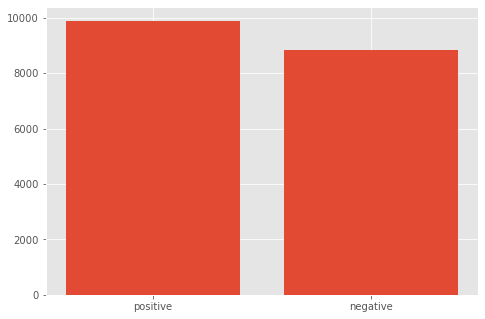

In [6]:
sentiments = ['positive', 'negative']
counts = [counts['positive'], counts['negative']]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(sentiments,counts)
plt.show()

## Preprocessing

In [7]:
# Handling the retweet(RT) tag
def replace_retweet(tweet, default_replace=""):
    tweet = re.sub('RT\s+', default_replace, tweet)
    return tweet

# Handling user tags(@)
def replace_user(tweet, default_replace="user"):
    tweet = re.sub('\B@\w+', default_replace, tweet)
    return tweet

# Replace emojis with meaningful text
def demojize(tweet):
    tweet = emoji.demojize(tweet)
    return tweet

def replace_url(tweet, default_replace=""):
    tweet = re.sub('(http|https):\/\/\S+', default_replace, tweet)
    return tweet

# Remove hashtag symbol(#)
def replace_hashtag(tweet, default_replace=""):
    tweet = re.sub('#+', default_replace, tweet)
    return tweet

def to_lowercase(tweet):
  tweet = tweet.lower()
  return tweet

def word_repetition(tweet):
  tweet = re.sub(r'(.)\1+', r'\1\1', tweet)
  return tweet

def punct_repetition(tweet, default_replace=""):
  tweet = re.sub(r'[\?\.\!]+(?=[\?\.\!])', default_replace, tweet)
  return tweet

# Replace contractions with their extended forms
def fix_contractions(tweet):
  tweet = contractions.fix(tweet)
  return tweet

In [8]:
def preprocessor(tweet, verbose=False):
    if verbose: print("Initial tweet: {}".format(tweet))

    ## Twitter Features
    tweet = replace_retweet(tweet) # replace retweet
    tweet = replace_user(tweet, "") # replace user tag
    tweet = replace_url(tweet) # replace url
    tweet = replace_hashtag(tweet) # replace hashtag
    if verbose: print("Post Twitter processing tweet: {}".format(tweet))

    ## Word Features
    tweet = to_lowercase(tweet) # lower case
    tweet = fix_contractions(tweet) # replace contractions
    tweet = punct_repetition(tweet) # replace punctuation repetition
    tweet = word_repetition(tweet) # replace word repetition
    tweet = demojize(tweet) # replace emojis
    if verbose: print("Post Word processing tweet: {}".format(tweet))

    return tweet

In [9]:
tweet_data['processed_text'] = tweet_data['tweet_text'].apply(preprocessor)

In [10]:
# Drop extra columns
tweet_data = tweet_data.drop(['textID', 'tweet_text'], axis=1)

In [11]:
# Add __label__ tags
tweet_data['sentiment']=['__label__'+s.replace(' or ', '$').replace(', or ','$').replace(',','$').replace(' ','_').replace(',','__label__').replace('$$','$').replace('$',' __label__').replace('___','__') for s in tweet_data['sentiment']]
tweet_data['processed_text']= tweet_data['processed_text'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)

In [12]:
tweet_data.head(5)

,sentiment,processed_text
0,__label__negative,layin n bed with a headache ughh.waitin on yo...
1,__label__negative,funeral ceremony.gloomy friday.
2,__label__positive,wants to hang out with friends soon!
3,__label__negative,re-pinging : why did not you go to prom? becau...
4,__label__negative,hmm. is down


## Split dataset

Train dataset size = 18727*75% = 14045

Test dataset size = 18727-14045 = 4682

In [13]:
tweet_data.head(14045).to_csv('tweet_data_fasttext.train.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')
tweet_data.tail(4682).to_csv('tweet_data_fasttext.test.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')

## Model training and prediction

In [14]:
# Train models using fastText and autotune hyperparameters
model = fasttext.train_supervised('tweet_data_fasttext.train.txt')

In [15]:
prediction = model.test_label('tweet_data_fasttext.test.txt')

## Model evaluation

In [16]:
def calculate_accuracy(model):
    #Getting data from a CSV
    labels = tweet_data['sentiment']
    tweets = tweet_data['processed_text']
    
    total, correct = 0, 0
    
    for idx, value in tweets.iteritems():
        #Predicting
        prediction = model.predict(value, k=1)
        
        #Saving accuracy
        total += 1
        if(prediction[0][0] == labels[idx]):
            correct += 1
            
    accuracy = correct / total
    print('accuracy = ' + 'correct/total = '+ str(correct) + '/' + str(total) + ' = ' + str(accuracy) + '\n')

In [17]:
def evaluate_model(dict):
    label_0 = dict['__label__negative']
    label_1 = dict['__label__positive']
    
    p0 = label_0['precision']
    r0 = label_0['recall']
    f0 = label_0['f1score']
    p1 = label_1['precision']
    r1 = label_1['recall']
    f1 = label_1['f1score']
    
    macro_precision = (p0 + p1) / 2
    macro_recall = (r0 + r1) / 2
    macro_f1 = (f0+ f1) / 2
    
    print('macro_precision = ' + str(macro_precision))
    print('macro_recall = ' + str(macro_recall))
    print('macro_f1 = ' + str(macro_f1))

In [18]:
evaluate_model(prediction)
calculate_accuracy(model)

macro_precision = 0.7147043421371386
macro_recall = 0.824614871740885
macro_f1 = 0.749833123275395
accuracy = correct/total = 17391/18727 = 0.928659155230416

